In [1]:
import numpy as np
import pandas as pd
from math import ceil, floor
from glob import glob
from tqdm.auto import tqdm

import sys
sys.path.insert(1, '/Users/prullens/Documents/GitHub/scChromTools/local/')
import scChromTools as scct

# Load metadata

In [2]:
CHROMS = [str(i) for i in list(range(1,23)) + ["X"]]

CHROMSIZES = 'hg19_chrom_sizes.tsv'
chromsizes = pd.read_csv(CHROMSIZES, sep='\t', header=None).groupby(0)[1].apply(int).to_dict()
BLACKLIST = 'hg19.blacklist.bed'

GTF = '/Users/prullens/metadata/Homo_sapiens.GRCh37.dna.gencode.v26lift37.basic.with_ERCC.gff' #https://www.gencodegenes.org/human/
BGZF = '/Users/prullens/metadata/Homo_sapiens.GRCh37.v93lift37.chr.gff3.bgzf' #https://github.com/phageghost/python-genome-browser

# Load data (available on GEO: GSE247458)

In [3]:
import scanpy as sc

*single-cell*

In [4]:
sc_100kb_adata = sc.read_h5ad('sc_damchic_human_binsize_100000.h5ad.gz')

sc_100kb_adata

AnnData object with n_obs × n_vars = 5055 × 30376
    obs: 'limsid', 'indexnr', 'barcodenr', 'construct', 'antibody', 'assay', 'cell_type', 'species', 'condition', 'cellcount', 'dam_counts', 'chic_counts', 'dam_counts_cas', 'dam_counts_129', 'chic_counts_cas', 'chic_counts_129', 'cellcycle_phase_via_facs', 'hoechst', 'cellcycle_phase_via_hoechst'
    layers: 'scDamID', 'sortChIC'

In [5]:
sc_5kb_adata = sc.read_h5ad('sc_damchic_human_binsize_5000.h5ad.gz')

sc_5kb_adata

AnnData object with n_obs × n_vars = 1692 × 27002
    obs: 'limsid', 'indexnr', 'barcodenr', 'construct', 'antibody', 'assay', 'cell_type', 'species', 'condition', 'cellcount', 'dam_counts', 'chic_counts', 'dam_counts_cas', 'dam_counts_129', 'chic_counts_cas', 'chic_counts_129', 'cellcycle_phase_via_facs', 'hoechst', 'cellcycle_phase_via_hoechst'
    layers: 'scDamID', 'sortChIC'

*in silico bulk*

In [6]:
bulk_damid_1kb_adata = sc.read_h5ad('damid_insilico_bulk_human_binsize_1000.h5ad.gz')

bulk_damid_1kb_adata

AnnData object with n_obs × n_vars = 4 × 3036315
    layers: 'scDamID'

In [7]:
bulk_chic_1kb_adata = sc.read_h5ad('chic_insilico_bulk_human_binsize_1000.h5ad.gz')

bulk_chic_1kb_adata

AnnData object with n_obs × n_vars = 12 × 3036315
    layers: 'sortChIC'

*input control*

In [8]:
input_1kb_adata = sc.read_h5ad('input_human_binsize_1000.h5ad.gz')

input_1kb_adata

AnnData object with n_obs × n_vars = 2 × 3036315
    layers: 'input'

*ENCODE (available at https://www.encodeproject.org/experiments)*

In [9]:
fnfmt = '/Users/prullens/Documents/projects/K562/experiments/{}/*.bed.gz'

fn_ab = {'ENCSR956DNB':'ATAC',
         'ENCSR668LDD':'H3K4me3',
         'ENCSR000EWB':'H3K27me3',
         'ENCSR000APE':'H3K9me3'
}

peak_dict = dict()
for fn in fn_ab:
    path = glob(fnfmt.format(fn))[0]
    df = pd.read_csv(path, sep='\t', header=None)
    df['chrom'] = df[0].str.split('r').str[-1]
    df['summit'] = df[[1,9]].sum(axis=1)
    df = df[df['chrom'].isin(CHROMS)]
    df = df[df['chrom'] != '8'] #chr8 is diploid in KBM7
    peak_dict[fn_ab[fn]] = df
    print(path,fn_ab[fn])

/Users/prullens/Documents/projects/K562/experiments/ENCSR956DNB/ENCSR956DNB.ENCLB310BBE.bed.gz ATAC
/Users/prullens/Documents/projects/K562/experiments/ENCSR668LDD/ENCSR668LDD.ENCFF752ALB.bed.gz H3K4me3
/Users/prullens/Documents/projects/K562/experiments/ENCSR000EWB/ENCSR000AKQ.ENCFF728DBX.bed.gz H3K27me3
/Users/prullens/Documents/projects/K562/experiments/ENCSR000APE/ENCSR000APE.ENCFF323KXF.bed.gz H3K9me3


In [10]:
encode_1kb_adata = sc.read_h5ad('encode_k562_binsize_1000.h5ad.gz')

encode_1kb_adata

AnnData object with n_obs × n_vars = 4 × 3036315
    layers: 'ENCODE'

______

____

# Formatting

*100Kb*

In [11]:
var_names = pd.Series(sc_100kb_adata.var_names)
damid_100kb_counts = {bc: dict() for bc in sc_100kb_adata.obs_names}
chic_100kb_counts = {bc: dict() for bc in sc_100kb_adata.obs_names}

for chrom in tqdm(CHROMS):
    idx = var_names.str.startswith('%s_' %chrom)
    damid_layer = sc_100kb_adata.layers['scDamID'][:,idx]
    chic_layer = sc_100kb_adata.layers['sortChIC'][:,idx]
    for i,bc in enumerate(sc_100kb_adata.obs_names):
        damid_100kb_counts[bc][chrom] = damid_layer[i]
        chic_100kb_counts[bc][chrom] = chic_layer[i]

  0%|          | 0/23 [00:00<?, ?it/s]

*5kb*

In [12]:
var_names = pd.Series(sc_5kb_adata.var_names)
damid_5kb_counts = {bc: dict() for bc in sc_5kb_adata.obs_names}
chic_5kb_counts = {bc: dict() for bc in sc_5kb_adata.obs_names}

for chrom in ['11']:
    idx = var_names.str.startswith('%s_' %chrom)
    damid_layer = sc_5kb_adata.layers['scDamID'][:,idx]
    chic_layer = sc_5kb_adata.layers['sortChIC'][:,idx]
    for i,bc in enumerate(sc_5kb_adata.obs_names):
        damid_5kb_counts[bc][chrom] = damid_layer[i]
        chic_5kb_counts[bc][chrom] = chic_layer[i]

*1Kb*

In [13]:
var_names = pd.Series(bulk_damid_1kb_adata.var_names)
damid_1kb_counts = {bc: dict() for bc in bulk_damid_1kb_adata.obs_names}
chic_1kb_counts = {bc: dict() for bc in bulk_chic_1kb_adata.obs_names}
input_1kb_counts = {bc: dict() for bc in input_1kb_adata.obs_names}
encode_1kb_counts = {bc: dict() for bc in encode_1kb_adata.obs_names}

for chrom in tqdm(CHROMS):
    idx = var_names.str.startswith('%s_' %chrom)
    
    damid_layer = bulk_damid_1kb_adata.layers['scDamID'][:,idx]
    for i,bc in enumerate(bulk_damid_1kb_adata.obs_names):
        damid_1kb_counts[bc][chrom] = damid_layer[i]
    chic_layer = bulk_chic_1kb_adata.layers['sortChIC'][:,idx]
    for i,bc in enumerate(bulk_chic_1kb_adata.obs_names):
        chic_1kb_counts[bc][chrom] = chic_layer[i]
    input_layer = input_1kb_adata.layers['input'][:,idx]
    for i,bc in enumerate(input_1kb_adata.obs_names):
        input_1kb_counts[bc][chrom] = input_layer[i]
    encode_layer = encode_1kb_adata.layers['ENCODE'][:,idx]
    for i,bc in enumerate(encode_1kb_adata.obs_names):
        encode_1kb_counts[bc][chrom] = encode_layer[i]

  0%|          | 0/23 [00:00<?, ?it/s]

*Rebin input control*

In [14]:
input_5kb_counts = scct.rebinning(input_1kb_counts, binsize=1_000, rebinsize=5_000)
input_100kb_counts = scct.rebinning(input_1kb_counts, binsize=1_000, rebinsize=100_000)

____

*Observed / Expected*

In [15]:
scct.compute_oe

<function scChromTools.compute_oe(counts_iter, binsize, chromsizes, depth_thrs=1000, pseudocount=0.1, minmap_per_kb=1, expected=None, blacklist=None, chroms=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X'], scaling_factor=None, disable_tqdm=False)>

*100kb*

In [16]:
damid_100kb_oe, _ = scct.compute_oe(damid_100kb_counts, 
                                    100_000, 
                                    CHROMSIZES, 
                                    0, 
                                    expected=input_100kb_counts['GATC'], 
                                    blacklist=BLACKLIST
)

  0%|          | 0/5055 [00:00<?, ?it/s]

/Users/prullens/Documents/GitHub/scChromTools/local/scChromTools.py:141: RuntimeWarning: invalid value encountered in true_divide
  scrpkm = {c: counts[c] / depth * 1e9 / binsize for c in chroms}


In [17]:
chic_100kb_oe, _ = scct.compute_oe(chic_100kb_counts, 
                                   100_000, 
                                   CHROMSIZES, 
                                   0, 
                                   expected=input_100kb_counts['MNase_H3'], 
                                   blacklist=BLACKLIST
)

  0%|          | 0/5055 [00:00<?, ?it/s]

*5Kb*

In [18]:
damid_5kb_oe, _ = scct.compute_oe(damid_5kb_counts, 
                                  5_000, 
                                  CHROMSIZES, 
                                  0, 
                                  expected=input_5kb_counts['GATC'], 
                                  blacklist=BLACKLIST, 
                                  chroms=['11'],
                                  disable_tqdm=True
)

In [19]:
chic_5kb_oe, _ = scct.compute_oe(chic_5kb_counts, 
                                 5_000, 
                                 CHROMSIZES, 
                                 0, 
                                 expected=input_5kb_counts['MNase_H3'], 
                                 blacklist=BLACKLIST,
                                 chroms=['11'],
                                 disable_tqdm=True
)

*1Kb*

In [20]:
damid_1kb_oe, _ = scct.compute_oe(damid_1kb_counts, 
                                  1_000, 
                                  CHROMSIZES, 
                                  0, 
                                  expected=input_1kb_counts['GATC'], 
                                  blacklist=BLACKLIST,
                                  disable_tqdm=True
)

In [21]:
chic_1kb_oe, _ = scct.compute_oe(chic_1kb_counts, 
                                 1_000, 
                                 CHROMSIZES, 
                                 0, 
                                 expected=input_1kb_counts['MNase_H3'], 
                                 blacklist=BLACKLIST,
                                 disable_tqdm=True
)

In [22]:
encode_1kb_rpkm, _ = scct.compute_oe(encode_1kb_counts, 
                                     1_000, 
                                     CHROMSIZES, 
                                     0, 
                                     blacklist=BLACKLIST,
                                     disable_tqdm=True
)

No expected file found... Return RPKM values instead. In addition, unmappable regions are not set to pseudocount.


____

# Plot settings

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import gaussian, fftconvolve
from matplotlib import ticker as mticker
import pygbrowse
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap as cmap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter

kwargs = {'dpi':150}

coldict = {'Dam-LMNB1':'#059E8F',
           'Dam':'#878693',
           'Dam-only':'#878693',
           'H3K4me3':'#9C7498',
           'H3K36me3':'#02679a',
           'H3K27me3':'#F2A25C',
           'H3K9me3':'#67819E'
}

violinprops = {'linewidth':1,
               'edgecolor':'k'
}

# Plotting

In [24]:
anno = sc_100kb_adata.obs

anno.head()

,limsid,indexnr,barcodenr,construct,antibody,assay,cell_type,species,condition,cellcount,dam_counts,chic_counts,dam_counts_cas,dam_counts_129,chic_counts_cas,chic_counts_129,cellcycle_phase_via_facs,hoechst,cellcycle_phase_via_hoechst
HMF1477.index12.006,HMF1477,12,6,Dam-LMNB1,H3K9me3,DamChIC,KBM7,human,unsynchronized,1,26646,5453,nan,nan,nan,nan,nan,nan,nan
HMF1477.index12.007,HMF1477,12,7,Dam-LMNB1,H3K9me3,DamChIC,KBM7,human,unsynchronized,1,15361,10806,nan,nan,nan,nan,nan,nan,nan
HMF1477.index12.008,HMF1477,12,8,Dam-LMNB1,H3K9me3,DamChIC,KBM7,human,unsynchronized,1,2238,10838,nan,nan,nan,nan,nan,nan,nan
HMF1477.index12.009,HMF1477,12,9,Dam-LMNB1,H3K9me3,DamChIC,KBM7,human,unsynchronized,1,15207,12721,nan,nan,nan,nan,nan,nan,nan
HMF1477.index12.010,HMF1477,12,10,Dam-LMNB1,H3K9me3,DamChIC,KBM7,human,unsynchronized,1,4107,9505,nan,nan,nan,nan,nan,nan,nan


In [25]:
gb = anno.groupby(['construct','antibody'])

gb.size().to_frame('Cells')

Cells
construct antibody       
Dam-LMNB1 H3K4me3     654
          H3K9me3     709
          H3K27me3    457
          LMNB1      1719
          none        215
Dam-only  H3K4me3     267
          H3K9me3     590
          H3K27me3    444
          LMNB1         0
          none          0

___

In [26]:
constructs = ['Dam-LMNB1','Dam-only']
antibodies = ['H3K4me3','H3K27me3','H3K9me3']

groups = [(c,ab) for c in constructs for ab in antibodies]

groups

[('Dam-LMNB1', 'H3K4me3'),
 ('Dam-LMNB1', 'H3K27me3'),
 ('Dam-LMNB1', 'H3K9me3'),
 ('Dam-only', 'H3K4me3'),
 ('Dam-only', 'H3K27me3'),
 ('Dam-only', 'H3K9me3')]

In [27]:
bcs = np.hstack([gb.groups[g] for g in groups])

bcs.size

3121

____

# Fig.1b - Unique counts

Text(0, 0.5, 'Unique counts')

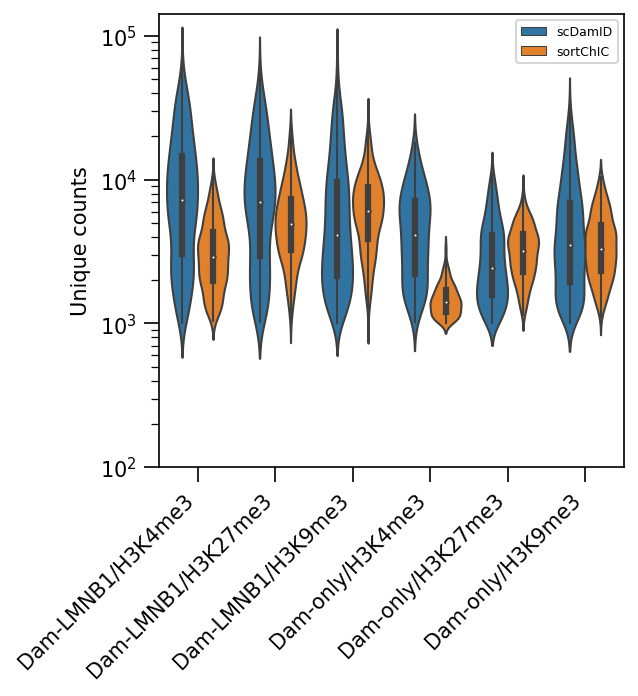

In [28]:
X = np.repeat(anno.loc[bcs,['construct','antibody']].agg('/'.join, axis=1), 2)
y = np.log10(np.hstack(anno.loc[bcs,['dam_counts','chic_counts']].values.astype(int)))
hue = np.tile(['scDamID','sortChIC'], bcs.size)

f, ax = plt.subplots(figsize=(4,4), **kwargs)

sns.violinplot(x=X, 
               y=y, 
               hue=hue, 
               scale='count', 
               **violinprops
)
ax.set_xticklabels(pd.unique(X), rotation=45, ha='right')

ax.set_ylim(2,5.4)
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
ymin, ymax = ax.get_ylim()
tick_range = np.arange(np.floor(ymin), ymax)
ax.yaxis.set_ticks(tick_range)
ax.yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
ax.tick_params(length=7)
ax.tick_params(length=4, which='minor')
ax.set_ylim(2,5.15)

ax.legend(prop={'size':6})
ax.set_ylabel('Unique counts')

___

# Fig.1c - Locus specific single-cell data

In [29]:
sc_binsize = 5_000
bulk_binsize = 1_000

In [30]:
genemodels = pygbrowse.datasources.Gff3Annotations('/Users/prullens/metadata/Homo_sapiens.GRCh37.v93lift37.chr.gff3.bgzf', 
                                                   component_types=('three_prime_UTR', 'five_prime_UTR')
)
genemodel_plotter = pygbrowse.plots.GeneModelPlot(genemodels, 
                                                  color='black', 
                                                  label='',
                                                  gene_name_fontsize=False, 
                                                  chevron_spacing=.8, chevron_height=0.02, chevron_width=0.01,
                                                  truncation_size=0.05, utr_endcap_width=0.01,
                                                  feature_height=.1
)

In [31]:
chrom, s, e = '11', 57e6, 65e6

#tracks
stracks = int(s/bulk_binsize)
etracks = int(e/bulk_binsize)
xaxis_tracks = np.arange(s, e, bulk_binsize)

smooth_stddev = 2500
wtracks = gaussian(ceil(smooth_stddev / bulk_binsize * 6 / 2) * 2 + 1, smooth_stddev / bulk_binsize)
wtracks /= wtracks.sum()

#heatmaps
smaps = int(s/sc_binsize)
emaps = int(e/sc_binsize)
xaxis_maps = np.arange(s, e, sc_binsize)

smooth_stddev = 5000
wmaps = gaussian(ceil(smooth_stddev / sc_binsize * 6 / 2) * 2 + 1, smooth_stddev / sc_binsize)
wmaps /= wmaps.sum()

Text(0.5, 0, 'Chromosome 11 (Mb)')

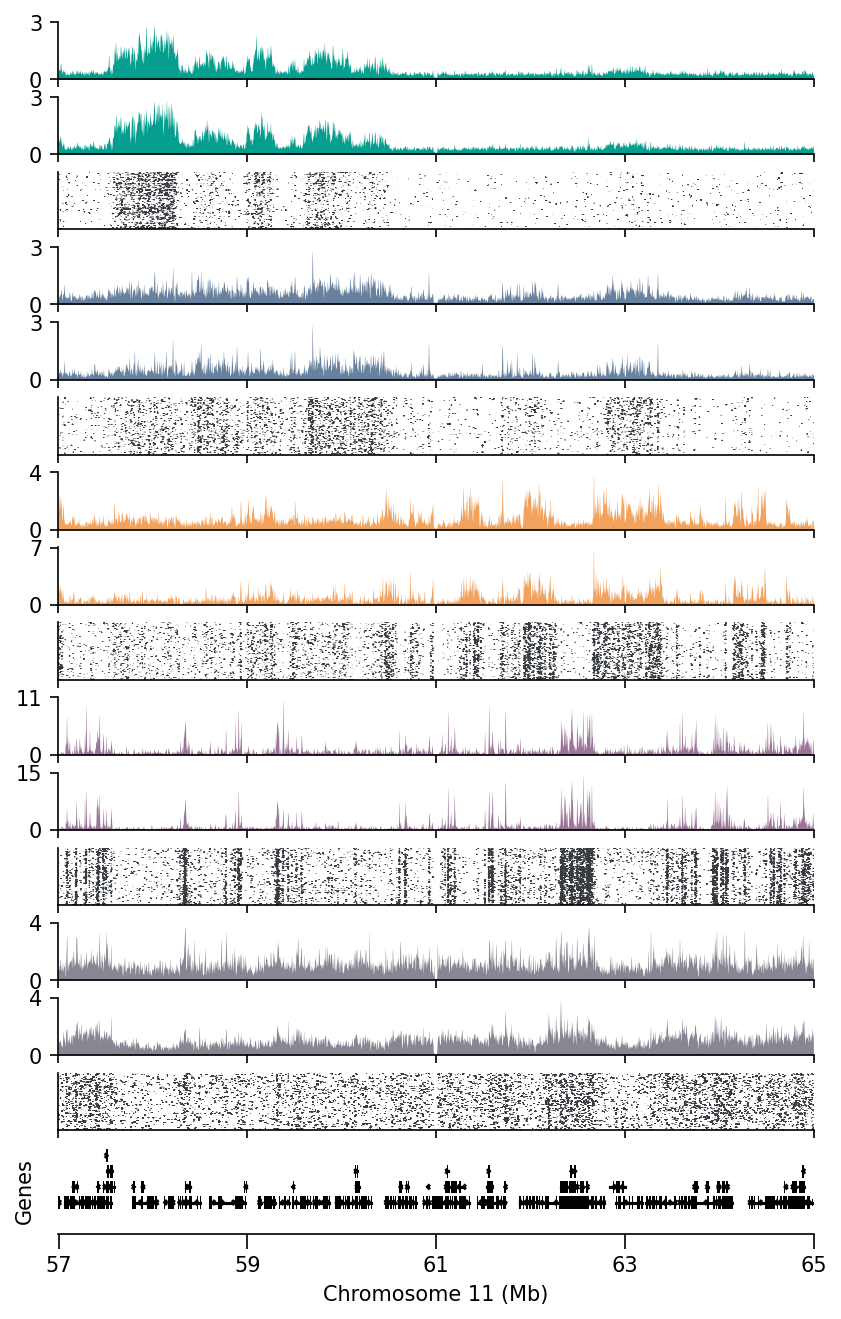

In [32]:
nrows, ncols = 16, 1
f, ax = plt.subplots(nrows, ncols, figsize=(6.5,10.7), 
                     gridspec_kw={'hspace':.3, 'height_ratios':[.1]*(nrows-1) + [.15]}, 
                     **kwargs
)

for i,k in zip([0,1,12,13],['Dam-LMNB1','Dam-LMNB1/H3K4me3','Dam','Dam/H3K4me3']):
    X = fftconvolve(damid_1kb_oe[k][chrom][stracks:etracks], wtracks, mode='same')
    ax[i].fill_between(xaxis_tracks, 
                       X, 
                       color=coldict[k.split('/')[0]],
                       lw=0
    )
    
for i,construct in zip([2,14],['Dam-LMNB1','Dam-only']):
    bcs = anno[(anno['construct'] == construct) & 
               (anno['antibody'].isin(antibodies)) & 
               (anno.index.isin(damid_5kb_oe))
    ].index
    X = np.array([fftconvolve(damid_5kb_oe[bc][chrom][smaps:emaps], wmaps, mode='same') 
                  for bc in bcs]
    )
    ax[i].imshow(X, 
                 aspect='auto', 
                 cmap=cmap.from_list('cbar',['white','#383c40']), 
                 vmin=1, 
                 vmax=2.5, 
                 extent=np.hstack([xaxis_maps[[0,-1]], 0,len(bcs)])
    )

for i,ab in enumerate(['H3K9me3','H3K27me3','H3K4me3']):
    i = (i + 1) * 3
    
    X = fftconvolve(chic_1kb_oe[ab][chrom][stracks:etracks], wtracks, mode='same')
    ax[i].fill_between(xaxis_tracks, 
                       X, 
                       color=coldict[ab],
                       lw=0
    )
    X = fftconvolve(chic_1kb_oe['Dam-LMNB1/%s' %ab][chrom][stracks:etracks], wtracks, mode='same')
    ax[i+1].fill_between(xaxis_tracks, 
                         X, 
                         color=coldict[ab],
                         lw=0
    )
    bcs = anno[(anno['antibody'] == ab) & 
               (anno.index.isin(chic_5kb_oe))
    ].index
    X = np.array([fftconvolve(chic_5kb_oe[bc][chrom][smaps:emaps], wmaps, mode='same') 
                  for bc in bcs]
    )
    ax[i+2].imshow(X, 
                   aspect='auto', 
                   cmap=cmap.from_list('cbar',['white','#383c40']), 
                   vmin=.5, 
                   vmax=3, 
                   extent=np.hstack([xaxis_maps[[0,-1]], 0,len(bcs)])
    )

for i in range(ax.size - 1):
    ax[i].margins(x=0)
    ax[i].set_ylim(0)
    ax[i].spines[['right','top']].set_visible(False)
    ymin, ymax = ax[i].get_ylim()
    ax[i].set_yticks([0,round(ymax, 1)])
    ax[i].set_yticklabels([round(ymin),str(round(ymax))])
    ax[i].tick_params(length=4)
    ax[i].set_xticklabels([])
    ax[i].set_xticks(np.arange(s, e+1, 2e6))
    
for i in np.arange(2,ax.size-1,3):
    ax[i].set_yticks([])
    
genemodel_plotter.plot(ax[-1], chrom, s, e, 8, 1, rotation=45)

ax[-1].tick_params(length=7)
ax[-1].spines['left'].set_visible(False)
ax[-1].spines['right'].set_visible(False)
ax[-1].spines['top'].set_visible(False)
ax[-1].set_yticks([])
ax[-1].set_ylabel('Genes')
ax[-1].set_ylim(-2)
ax[-1].margins(x=0)
ax[-1].set_xticks(np.arange(s, e+1, 2e6))
ax[-1].set_xticklabels((np.arange(s, e+1, 2e6) / 1e6).astype(int))
ax[-1].set_xlabel('Chromosome %s (Mb)' %chrom)

____

# Fig.1d - Alignment over genes

In [33]:
gtf = scct.load_gtf(GTF)

gtf.head(), gtf.shape

(  Chromosome      Start        End Strand        tss               gene_id  \
 0          X   99882105   99894988      -   99894988  ENSG00000000003.14_2   
 1          X   99839798   99854882      +   99839798   ENSG00000000005.5_2   
 2         20   49551403   49575092      -   49575092  ENSG00000000419.12_2   
 3          1  169818771  169863408      -  169863408  ENSG00000000457.13_2   
 4          1  169631244  169823221      +  169631244  ENSG00000000460.16_3   
 
   gene_name Feature  
 0    TSPAN6    gene  
 1      TNMD    gene  
 2      DPM1    gene  
 3     SCYL3    gene  
 4  C1orf112    gene  ,
 (60028, 8))

In [34]:
rnaseq = pd.read_csv('rooijers_2019_kbm7_rnaseq.tsv.gz', sep='\t', index_col=0) #https://www.nature.com/articles/s41587-019-0150-y

rnaseq.head(), rnaseq.size

(   KBM7_mean_expression
 0              0.473811
 1              0.000000
 2             66.846720
 3              4.495907
 4             12.594335,
 60028)

In [35]:
gtf = pd.concat([gtf, rnaseq['KBM7_mean_expression']], axis=1)

gtf.shape

(60028, 9)

In [36]:
emin, emax = np.percentile(gtf['KBM7_mean_expression'], 75), np.percentile(gtf['KBM7_mean_expression'], 95)
regions = gtf.loc[(gtf['Chromosome'].isin(CHROMS)) & 
                  (gtf['KBM7_mean_expression'] > emin) & 
                  (gtf['KBM7_mean_expression'] < emax), ['Chromosome','Start','End','Strand','KBM7_mean_expression']].values

expression = regions[:,-1]
strand = regions[:,-2]
regions = regions[:,:-2]

regions, regions.shape

(array([['1', 169818771, 169863408],
        ['1', 169631244, 169823221],
        ['1', 196621007, 196716634],
        ...,
        ['1', 211031466, 211307488],
        ['9', 22703514, 23438698],
        ['1', 31971826, 32048907]], dtype=object),
 (11966, 3))

Dam
H3K4me3
H3K27me3
H3K9me3
Dam-LMNB1


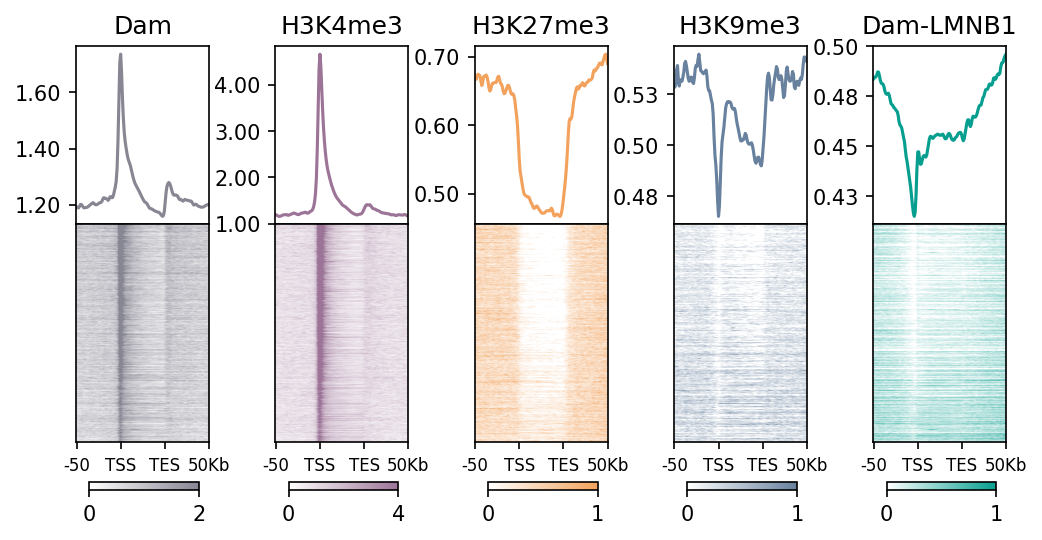

In [38]:
window = 50_000

nrows, ncols = 2, len(antibodies) + 2
f, ax = plt.subplots(nrows, ncols, figsize=(8,3.5), 
                     gridspec_kw={'height_ratios':[.45,.55],'hspace':0,'wspace':.5}, 
                     **kwargs
)

for i,k in enumerate(['Dam/H3K4me3',
                      'Dam-LMNB1/H3K4me3',
                      'Dam-LMNB1/H3K27me3',
                      'Dam-LMNB1/H3K9me3',
                      'Dam-LMNB1/H3K4me3']):
    if i in (0,4):
        data = damid_1kb_oe[k]
        k = k.split('/')[0]
    else:
        data = chic_1kb_oe[k]
        k = k.split('/')[1]
    a2d, bounds = scct.scale_regions(regions, 
                                     data, 
                                     1_000, 
                                     window, 
                                     strand=strand
    )
    
    _argsort = np.argsort(expression[bounds])
    a2d = gaussian_filter(a2d[bounds], sigma=1)[_argsort]
    
    ax[0,i].plot(a2d.mean(0), 
                 color=coldict[k]
    )
    vmin, vmax = [.95,.5,.45,.45,.4][i], [1.6,3.5,1,.85,.75][i]
    im = ax[1,i].imshow(a2d, 
                        aspect='auto', 
                        cmap=cmap.from_list('cbar',['white',coldict[k]]), 
                        origin='lower', 
                        vmin=vmin, 
                        vmax=vmax
    )
    axins = inset_axes(ax[1,i],
                       width="55%",  
                       height="4%",
                       loc='lower left',
                       bbox_to_anchor=(.1, -.22, 1.5, 1),
                       bbox_transform=ax[1,i].transAxes,
                       borderpad=0,
                       )
    cbar = f.colorbar(im, ax=ax[1,i], cax=axins, orientation='horizontal', pad=.06, ticks=[vmin,vmax])
    cbar.set_ticklabels([floor(vmin),ceil(vmax)])
    
    ax[0,i].set_title(k)
    ax[0,i].margins(x=0)
    ax[0,i].set_xticks([])
    ax[1,i].set_xticks([0,50,100,150])
    ax[1,i].set_xticklabels([])
    ax[1,i].set_yticks([])
    
    ax[0,i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[1,i].set_xticklabels([-50,'TSS','TES','50Kb'], fontsize=8)
    
    print(k)

______

# Fig.1e - genome-wide correlation 

In [39]:
smooth_stddev = 25_000

damid_1kb_oe_smooth = scct.gaussian_smoothing(damid_1kb_oe, 1_000, smooth_stddev)
chic_1kb_oe_smooth = scct.gaussian_smoothing(chic_1kb_oe, 1_000, smooth_stddev)

In [40]:
#select mappable 1Kb-bins 
idx = np.sum([np.hstack(list(chic_1kb_oe[k].values())) > .101 for k in chic_1kb_oe], axis=0) > 0

idx.sum(), idx.shape

(1967978, (3036315,))

In [41]:
samples = [k for k in chic_1kb_oe if k.split('/')[-1] in antibodies]

a2d = np.array([np.hstack(list(chic_1kb_oe_smooth[k].values()))[idx] for k in samples])

a2d = np.r_[a2d,
            np.array([np.hstack(list(damid_1kb_oe_smooth[k].values()))[idx] for k in ['Dam','Dam/H3K4me3']])
]
samples += ['Dam','Dam/H3K4me3']

a2d.shape, len(samples)

((11, 1967978), 11)

In [42]:
def pearsonr_matrix_dot(M):
    x = M
    y = M
    mu_x = x.mean(1)
    mu_y = y.mean(1)
    n = x.shape[1]
    s_x = x.std(1, ddof=n - 1)
    s_y = y.std(1, ddof=n - 1)
    cov = np.dot(x,
                 y.T) - n * np.dot(mu_x[:, np.newaxis],
                                  mu_y[np.newaxis, :])
    cov /= np.dot(s_x[:, np.newaxis], s_y[np.newaxis, :])
    cov[np.isnan(cov)] = 0
    cov[np.isinf(cov)] = 0
    return cov

In [43]:
p = pearsonr_matrix_dot(a2d)

p.shape

(11, 11)

In [44]:
df = pd.DataFrame(p, index=samples, columns=samples)

df.shape

(11, 11)

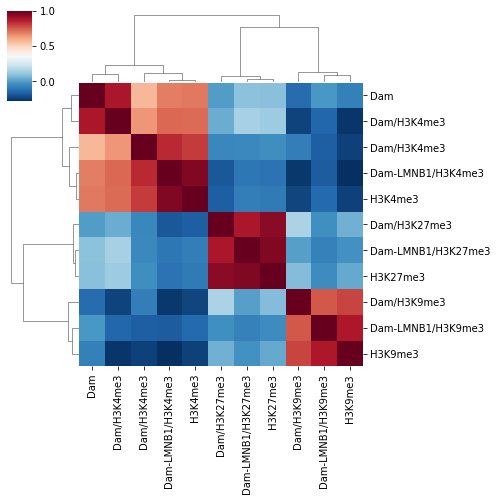

In [45]:
sns.clustermap(df, figsize=(7,7), cmap='RdBu_r', annot=False)

______

# Fig.1f - UMAP

*Format data*

In [46]:
#mild gaussian smoothing 
smooth_stddev = 150_000

damid_100kb_oe_smooth = scct.gaussian_smoothing(damid_100kb_oe, 100_000, smooth_stddev, disable_tqdm=False)
chic_100kb_oe_smooth = scct.gaussian_smoothing(chic_100kb_oe, 100_000, smooth_stddev, disable_tqdm=False)

  0%|          | 0/5055 [00:00<?, ?it/s]

  0%|          | 0/5055 [00:00<?, ?it/s]

In [47]:
#select mapapble bins
damid_idx = np.hstack(list(damid_100kb_oe[list(damid_100kb_oe)[0]].values())) > .101
chic_idx = np.hstack(list(chic_100kb_oe[list(chic_100kb_oe)[0]].values())) > .101

idx = damid_idx & chic_idx

damid_idx.sum(), chic_idx.sum(), idx.sum()

(27787, 25455, 25455)

In [48]:
bcs = np.r_[np.hstack([gb.groups[g] for g in groups]), 
            np.hstack([gb.groups[g] for g in groups])]

bcs.size

6242

In [49]:
damid_a2d = np.vstack([[np.hstack(list(damid_100kb_oe_smooth[bc].values()))[idx] 
                        for bc in gb.groups[g]] for g in groups]
)
chic_a2d = np.vstack([[np.hstack(list(chic_100kb_oe_smooth[bc].values()))[idx] 
                       for bc in gb.groups[g]] for g in groups]
)
damid_a2d.shape, chic_a2d.shape

((3121, 25455), (3121, 25455))

In [50]:
a2d = np.r_[damid_a2d, chic_a2d]

a2d.shape

(6242, 25455)

In [51]:
hue = np.r_[np.hstack([np.repeat(g[0],gb.groups[g].size) for g in groups]),
             np.hstack([np.repeat(g[1],gb.groups[g].size) for g in groups])
]

hue.size

6242

*PCA*

In [52]:
from sklearn.decomposition import PCA

In [53]:
pca = PCA(n_components=50, random_state=2)
_pca = pca.fit_transform(a2d).T

_pca.shape

(50, 6242)

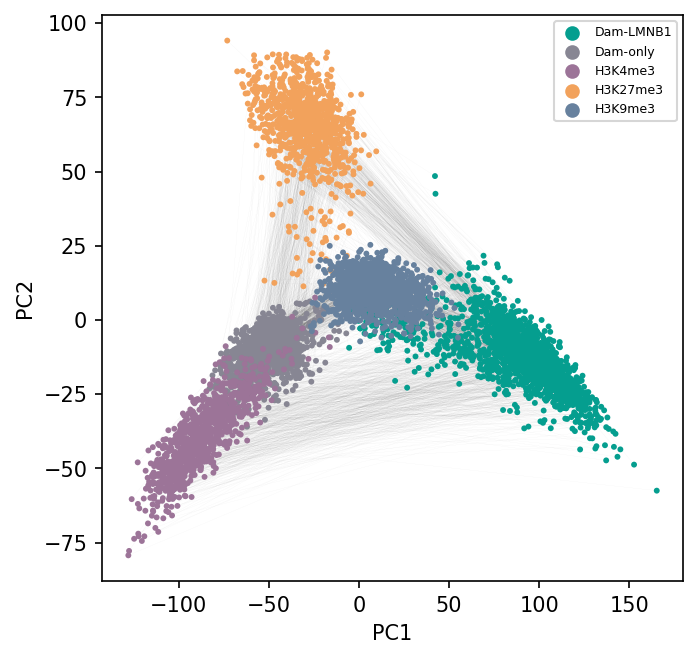

In [54]:
X, y = _pca[0], _pca[1]

split_idx = bcs.size // 2

x0, x1 = X[:split_idx], X[split_idx:]
y0, y1 = y[:split_idx], y[split_idx:]

f, ax = plt.subplots(figsize=(5,5), **kwargs)

sns.scatterplot(x=X, 
                y=y, 
                hue=hue, 
                s=8,
                linewidth=0, 
                edgecolor='k',
                palette=[coldict[g] for g in pd.unique(hue)]
)
ax.plot([x0, x1], 
        [y0, y1], 
        c='k', 
        lw=.01, 
        zorder=0, 
        alpha=.5
)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend(prop={'size':6})

*UMAP*

In [56]:
import umap as UMAP

In [57]:
umap = UMAP.UMAP(n_components=2, 
                 n_neighbors=30, 
                 min_dist=1, 
                 metric='correlation', 
                 random_state=10
) 
_umap = umap.fit_transform(_pca.T)

_umap.shape

OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(6242, 2)

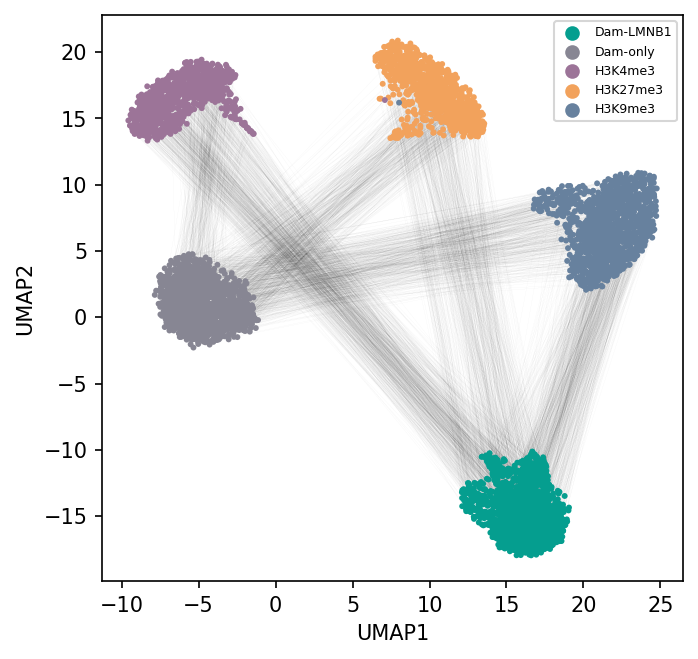

In [58]:
X, y = _umap.T

split_idx = bcs.size // 2

x0, x1 = X[:split_idx], X[split_idx:]
y0, y1 = y[:split_idx], y[split_idx:]

f, ax = plt.subplots(figsize=(5,5), **kwargs)

sns.scatterplot(x=X, 
                y=y, 
                hue=hue, 
                s=8,
                linewidth=0, 
                edgecolor='k',
                palette=[coldict[g] for g in pd.unique(hue)]
)
ax.plot([x0, x1], 
        [y0, y1], 
        c='k', 
        lw=.01, 
        zorder=0, 
        alpha=.5
)
ax.legend(prop={'size':5})
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.legend(prop={'size':6})

_______

# Fig.S1f - comparison with multifactorial methods

In [59]:
df = pd.read_csv('multifactor_comparison.tsv', sep='\t')

df.head()

,study,log10(counts),factor
0,this_study,3.704065,Dam-LMNB1
1,this_study,3.847696,Dam-LMNB1
2,this_study,4.357382,Dam-LMNB1
3,this_study,4.004235,Dam-LMNB1
4,this_study,4.651908,Dam-LMNB1


Text(0, 0.5, 'Unique counts')

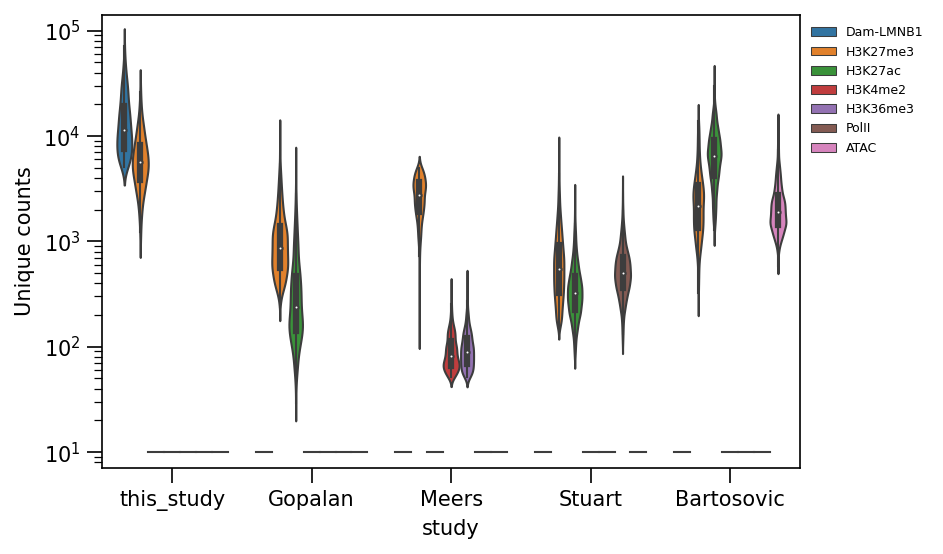

In [60]:
f, ax = plt.subplots(figsize=(6,4), **kwargs)

sns.violinplot(x=df['study'], 
               y=df['log10(counts)'], 
               hue=df['factor'], 
               scale_hue='count',
               **violinprops
)

ax.set_ylim(top=5.4)
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
ymin, ymax = ax.get_ylim()
tick_range = np.arange(np.floor(ymin), ymax)
ax.yaxis.set_ticks(tick_range)
ax.yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
ax.tick_params(length=7)
ax.tick_params(length=4, which='minor')
ax.set_ylim(.85,5.15)

ax.legend(prop={'size':6}, bbox_to_anchor=(1,1), frameon=False)
ax.set_ylabel('Unique counts')

_____

# Fig.S1g - normmalization controls

Text(0.5, 0, 'Chromosome 1 (Mb)')

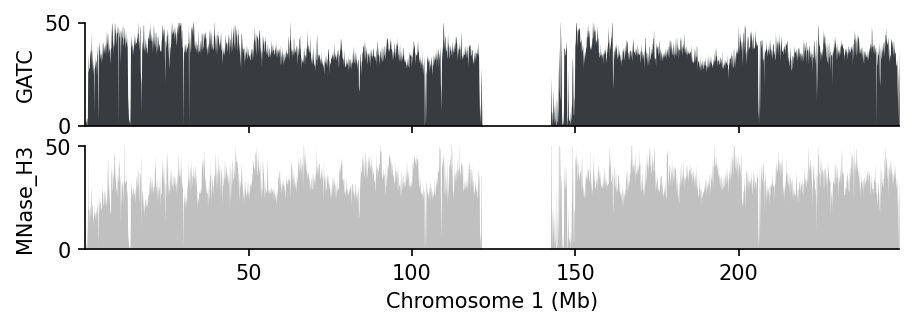

In [61]:
chrom = '1'
xaxis = np.arange(9,chromsizes[chrom],100_000) / 1e6

f, ax = plt.subplots(2, 1, figsize=(7,2), **kwargs)


for i,k in enumerate(input_100kb_counts):
    X = input_100kb_counts[k][chrom]
    X = X / (np.hstack(list(input_100kb_counts[k].values())).sum() / 1e6)
    X[X > np.percentile(X, 99.9)] = 0
    ax[i].fill_between(xaxis, 
                       X, 
                       color=['#383c40','silver'][i], 
                       lw=0
    )
    ax[i].set_ylim(0,50)
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].set_yticks([0,50])
    ax[i].margins(x=0)
    ax[i].set_ylabel(k)
    
ax[0].set_xticklabels([])
ax[1].set_xlabel('Chromosome %s (Mb)' %chrom)

______

# Fig.S1h - Alignment over LADs

In [62]:
lads = pd.read_csv('rooijers_2019_kbm7_lads.bed', sep='\t', header=None)

lads.head(), lads.shape

(   0         1         2
 0  1  48600000  49000000
 1  1  49300000  50700000
 2  1  55800000  58900000
 3  1  60200000  62100000
 4  1  62200000  62600000,
 (867, 3))

Dam
H3K4me3
H3K27me3
H3K9me3
Dam-LMNB1


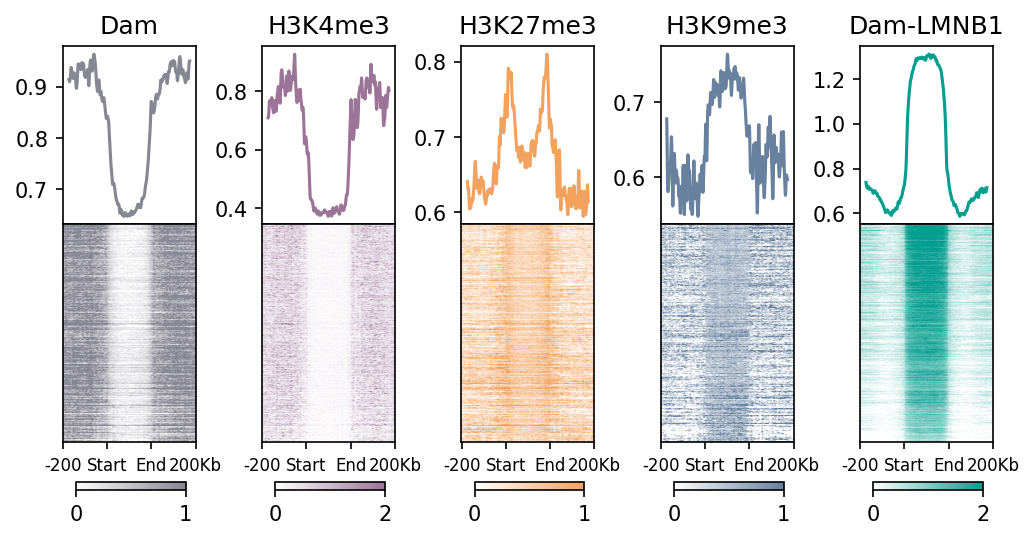

In [63]:
regions = lads[lads[0] != '8'].values #chr8 is diploid in KBM7

window = 200_000

nrows, ncols = 2, len(antibodies) + 2
f, ax = plt.subplots(nrows, ncols, figsize=(8,3.5), 
                     gridspec_kw={'height_ratios':[.45,.55],'hspace':0,'wspace':.5}, 
                     **kwargs
)

_groups = ['Dam/H3K4me3',
           'Dam-LMNB1/H3K4me3',
           'Dam-LMNB1/H3K27me3',
           'Dam-LMNB1/H3K9me3',
           'Dam-LMNB1/H3K4me3'
]

a2d, bounds = scct.scale_regions(regions, damid_1kb_oe[_groups[-1]], 1_000, window)
a2d = a2d[bounds]
_argsort = np.argsort(a2d[:,200:400].mean(1))

for i,k in enumerate(_groups):
    if i in (0,4):
        data = damid_1kb_oe[k]
        k = k.split('/')[0]
    else:
        data = chic_1kb_oe[k]
        k = k.split('/')[1]
    a2d, bounds = scct.scale_regions(regions, 
                                     data, 
                                     1_000, 
                                     window
    )
    a2d = gaussian_filter(a2d[bounds], sigma=2)[_argsort]
    
    ax[0,i].plot(a2d.mean(0), 
                 color=coldict[k]
    )
    vmin, vmax = [.6,.3,.4,.5,.5][i], [1,2,1,.8,1.5][i]
    im = ax[1,i].imshow(a2d, 
                        aspect='auto', 
                        cmap=cmap.from_list('cbar',['white',coldict[k]]), 
                        origin='lower', 
                        vmin=vmin, 
                        vmax=vmax
    )
    axins = inset_axes(ax[1,i],
                       width="55%",  
                       height="4%",
                       loc='lower left',
                       bbox_to_anchor=(.1, -.22, 1.5, 1),
                       bbox_transform=ax[1,i].transAxes,
                       borderpad=0,
                       )
    cbar = f.colorbar(im, ax=ax[1,i], cax=axins, orientation='horizontal', pad=.06, ticks=[vmin,vmax])
    cbar.set_ticklabels([floor(vmin),ceil(vmax)])
    
    ax[0,i].set_title(k)
    ax[0,i].set_xticks([])
    ax[1,i].set_xticks([0,200,400,600])
    ax[1,i].set_yticks([])
    ax[1,i].set_xticklabels([-200,'Start','End','200Kb'], fontsize=8)
    ax[0,i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    print(k)

____

# Fig.1I - locus comparison to ENCODE (K562)

In [64]:
chrom, s, e = '1', 45e6, 55e6

binsize = 1_000

stracks = int(s/binsize)
etracks = int(e/binsize)
xaxis_tracks = np.arange(s, e, binsize)

smooth_stddev = 2500
wtracks = gaussian(ceil(smooth_stddev / binsize * 6 / 2) * 2 + 1, smooth_stddev / binsize)
wtracks /= wtracks.sum()

Text(0.5, 0, 'Chromosome 1 (Mb)')

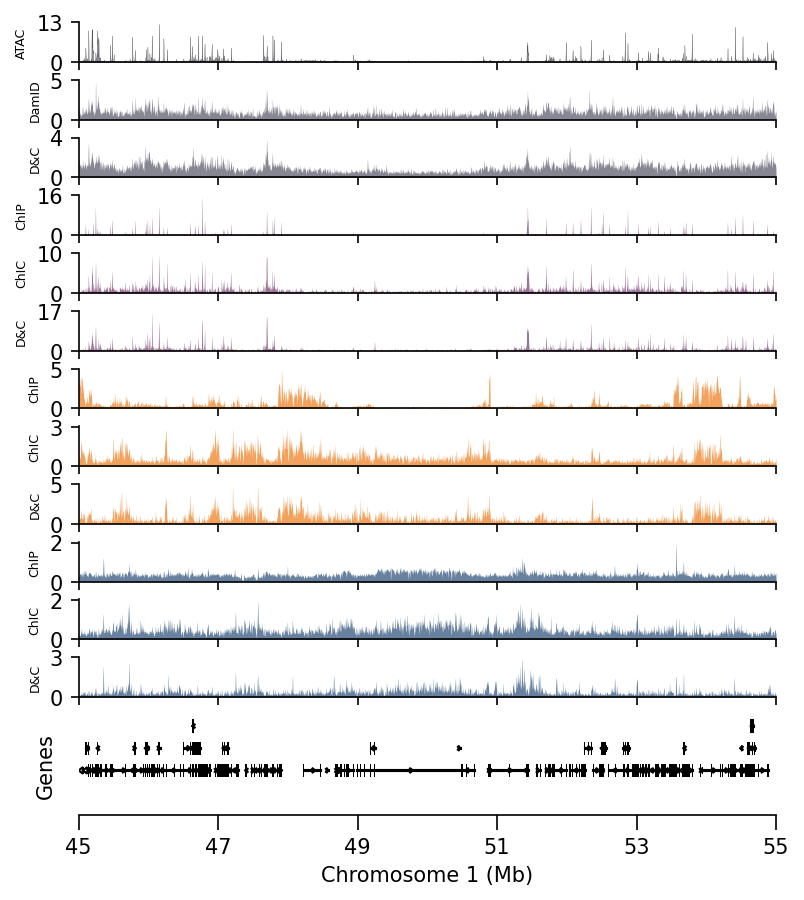

In [65]:
nrows, ncols = 3 + (len(antibodies) * 3) + 1, 1
f, ax = plt.subplots(nrows, 
                     ncols, 
                     figsize=(6,7), 
                     gridspec_kw={'hspace':.4, 
                                  'height_ratios':[.1]*(nrows-1) + [.25]},
                     **kwargs)


X = fftconvolve(encode_1kb_rpkm['ATAC'][chrom][stracks:etracks], wtracks, mode='same')
ax[0].fill_between(xaxis_tracks, 
                   X, 
                   color=coldict['Dam-only'], 
                   lw=.075,
                   edgecolor='k'
)
for i,k in enumerate(['Dam','Dam/H3K4me3']):
    X = fftconvolve(damid_1kb_oe[k][chrom][stracks:etracks], wtracks, mode='same')
    ax[i+1].fill_between(xaxis_tracks, 
                         X, 
                         color=coldict['Dam'], 
                         lw=0
    )

for i,ab in enumerate(antibodies):
    i = (i * 3) + 3
    
    X = fftconvolve(encode_1kb_rpkm[ab][chrom][stracks:etracks], wtracks, mode='same')
    ax[i].fill_between(xaxis_tracks, 
                       X, 
                       color=coldict[ab], 
                       lw=0
    )
    X = fftconvolve(chic_1kb_oe[ab][chrom][stracks:etracks], wtracks, mode='same')
    ax[i+1].fill_between(xaxis_tracks, 
                         X, 
                         color=coldict[ab], 
                         lw=0
    )
    X = fftconvolve(chic_1kb_oe['Dam-LMNB1/%s' %ab][chrom][stracks:etracks], wtracks, mode='same')
    ax[i+2].fill_between(xaxis_tracks, 
                         X, 
                         color=coldict[ab], 
                         lw=0
    )
    
for i in range(ax.size - 1):
    ax[i].margins(x=0)
    ax[i].set_ylim(0)
    ax[i].spines[['right','top']].set_visible(False)
    ymin, ymax = ax[i].get_ylim()
    ax[i].set_yticks([0,round(ymax, 1)])
    ax[i].set_yticklabels([round(ymin),str(round(ymax))])
    ax[i].tick_params(length=4)
    ax[i].set_xticklabels([])
    ax[i].set_xticks(np.arange(s, e+1, 2e6))
    
for i in range(0,ax.size - 1,3):
    ax[i].set_ylabel('ChIP', fontsize=6)
    ax[i+1].set_ylabel('ChIC', fontsize=6)
    ax[i+2].set_ylabel('D&C', fontsize=6)
ax[0].set_ylabel('ATAC', fontsize=6)
ax[1].set_ylabel('DamID', fontsize=6)

genemodel_plotter.plot(ax[-1], chrom, s, e, 8, 1, rotation=0)
ax[-1].tick_params(length=7)
ax[-1].spines['left'].set_visible(False)
ax[-1].spines['right'].set_visible(False)
ax[-1].spines['top'].set_visible(False)
ax[-1].set_yticks([])
ax[-1].set_ylabel('Genes')
ax[-1].set_ylim(-2)
ax[-1].margins(x=0)
ax[-1].set_xticks(np.arange(s, e+1, 2e6))
ax[-1].set_xticklabels((np.arange(s, e+1, 2e6) / 1e6).astype(int))
ax[-1].set_xlabel('Chromosome %s (Mb)' %chrom)

______

# Fig.1I - genome-wide comparison to ENCODE (K562)

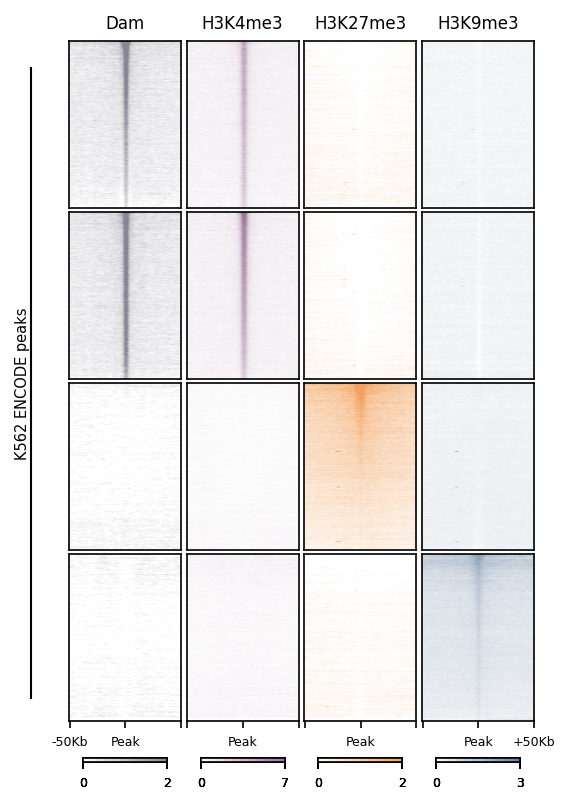

In [67]:
_groups = ['Dam'] + antibodies

topn = 10_000 #n top peaks 
window = 50_000

nrows, ncols = len(_groups), len(_groups)
f, ax = plt.subplots(nrows, 
                     ncols, 
                     figsize=(1*ncols,1.5*nrows), 
                     gridspec_kw={'hspace':.025,'wspace':.05}, 
                     **kwargs
)

for irow,k in enumerate(_groups):
    p = 'ATAC' if k == 'Dam' else k 
    anchors = peak_dict[p][['chrom','summit']].iloc[:topn].values

    #sort rows on peak-matching dataset
    data = damid_1kb_oe[k] if k == 'Dam' else chic_1kb_oe[k]
    a2d, bounds = scct.compute_profile(anchors, 
                                       data, 
                                       1_000, 
                                       window
    )
    a2d = a2d[bounds]
    _argsort = np.argsort(a2d[:,int(a2d.shape[1] * .45):int(a2d.shape[1] * .55)].mean(axis=1))
    for icol,k in enumerate(_groups):
        color = coldict[k]
        data = damid_1kb_oe[k] if k == 'Dam' else chic_1kb_oe[k]
        
        a2d, bounds = scct.compute_profile(anchors, 
                                           data, 
                                           1_000, 
                                           window
        )
        a2d = gaussian_filter(a2d[bounds], sigma=1)
        
        vmin, vmax = [.95,.5,.55,.35][icol], [2,7,1.65,2.1][icol]
        im = ax[irow,icol].imshow(a2d[_argsort], 
                                  vmin=vmin, 
                                  vmax=vmax, 
                                  cmap=cmap.from_list('cbar',['white',color]), 
                                  aspect='auto', 
                                  origin='lower'
        )
        ax[0,icol].set_title(k, fontsize=8)
        ax[irow,icol].set_xticks([])
        ax[irow,icol].set_yticks([])
        
        axins = inset_axes(ax[-1,icol],
                           width="50%",
                           height="2.5%",  
                           loc='lower left',
                           bbox_to_anchor=(.125, -.25, 1.5, 1),
                           bbox_transform=ax[-1,icol].transAxes,
                           borderpad=0,
        )
        cbar = f.colorbar(im, ax=ax[-1,icol], cax=axins, orientation='horizontal', pad=.06, ticks=[vmin,vmax])
        cbar.set_ticklabels([floor(vmin),ceil(vmax)], fontsize=6)  

for icol,k in enumerate(_groups):
    ax[-1,icol].set_xticks([0,50,100])
    ax[-1,icol].set_xticklabels(['','Peak',''], fontsize=6)
    
ax[-1,0].set_xticklabels(['-50Kb','Peak',''], fontsize=6)
ax[-1,-1].set_xticklabels(['','Peak','+50Kb'], fontsize=6)

f.text(0.035, 0.5, 'K562 ENCODE peaks', va='center', rotation='vertical', fontsize=7)

line = plt.Line2D((.0625,.0625),(.15,.85), color="k", linewidth=1)
f.add_artist(line)